<a href="https://colab.research.google.com/github/Durga-Kondaveeti/AI-trading-bot/blob/main/computer_vision_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip -q install transformers torchvision torch pillow tqdm matplotlib numpy


In [1]:
import os, json, math, random
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Imports done. Using device = {device}")


✅ Imports done. Using device = cuda


In [ ]:
from torchvision.datasets import CIFAR10
from torchvision.transforms.functional import to_pil_image

# small subset for speed; increase to 500/1000 later
N = 200

ds = CIFAR10(root="./data", train=False, download=True)
class_names = ds.classes

idxs = list(range(len(ds)))
random.shuffle(idxs)
idxs = idxs[:N]

images = []
labels = []
captions = []

for i in idxs:
    img, y = ds[i]             # img is PIL already for CIFAR10
    images.append(img.convert("RGB"))
    labels.append(y)
    captions.append(f"a photo of a {class_names[y]}")

print("✅ Step 3: Dataset ready")
print("   Samples:", len(images))
print("   Example caption:", captions[0])


✅ Step 3: Dataset ready
   Samples: 200
   Example caption: a photo of a dog


In [ ]:
model_name = "openai/clip-vit-base-patch32"

clip = CLIPModel.from_pretrained(model_name).to(device).eval()
processor = CLIPProcessor.from_pretrained(model_name)

print("✅ Step 4: Loaded CLIP:", model_name)


✅ Step 4: Loaded CLIP: openai/clip-vit-base-patch32


In [ ]:
@torch.no_grad()
def encode_images(pil_images, batch_size=32):
    embs = []
    for i in tqdm(range(0, len(pil_images), batch_size), desc="Encoding images"):
        batch = pil_images[i:i+batch_size]
        inputs = processor(images=batch, return_tensors="pt").to(device)
        feats = clip.get_image_features(**inputs)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        embs.append(feats.detach().cpu().numpy().astype("float32"))
    return np.vstack(embs)

img_emb = encode_images(images, batch_size=32)
print("✅ Step 5: Built image embedding matrix:", img_emb.shape)



Encoding images: 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]

✅ Step 5: Built image embedding matrix: (200, 512)


In [ ]:
@torch.no_grad()
def encode_text(texts):
    inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
    feats = clip.get_text_features(**inputs)
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats.detach().cpu().numpy().astype("float32")

q = input("Enter a text prompt: ").strip()
if q not in ['ship', 'dog', 'bird', 'deer']:
    print("No match")
else:
    q_emb = encode_text([q])[0]
    idx, sc = search_baseline(q_emb, topk=6)

    print("✅ Prompt:", q)
    print("Top labels:", [class_names[labels[i]] for i in idx])
    print("Scores:", [round(float(s), 3) for s in sc])

    show_results(idx, title=f"Baseline Top-6 for: {q}")



Enter a text prompt: tower
No match


✅ Step 7: Baseline retrieval done
   Top labels: ['dog', 'dog', 'dog', 'dog', 'dog', 'dog']


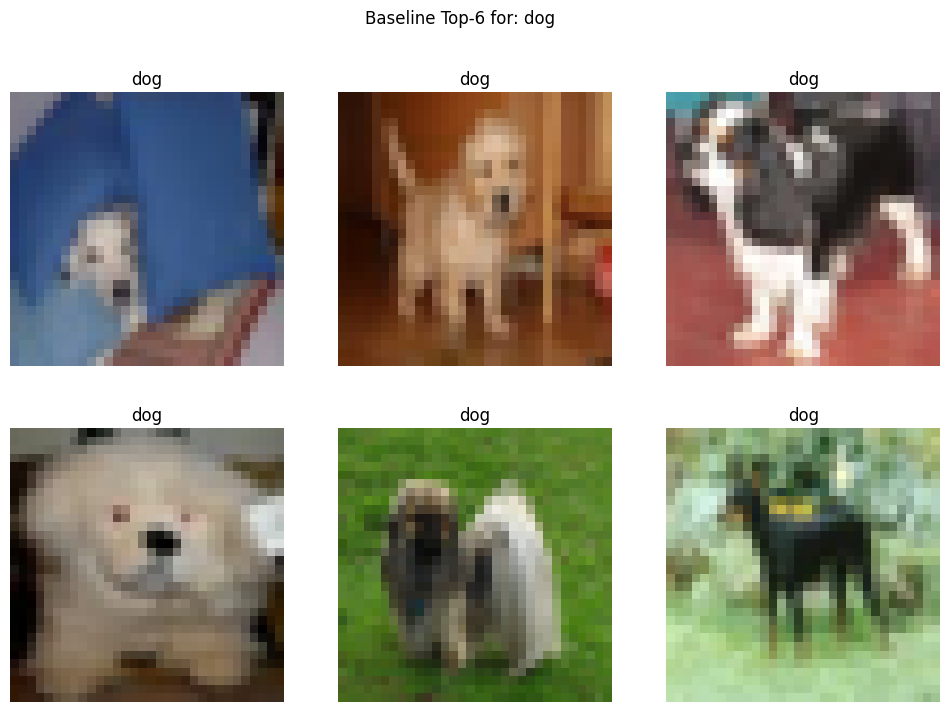

In [ ]:
def search_baseline(query_emb, topk=6):
    scores = img_emb @ query_emb  # cosine because normalized
    idx = np.argsort(-scores)[:topk]
    return idx, scores[idx]

def show_results(indices, title="", ncols=3):
    n = len(indices)
    nrows = math.ceil(n / ncols)
    plt.figure(figsize=(4*ncols, 4*nrows))
    for j, i in enumerate(indices):
        plt.subplot(nrows, ncols, j+1)
        plt.imshow(images[i], interpolation="nearest")
        plt.axis("off")
        plt.title(f"{class_names[labels[i]]}")
    plt.suptitle(title)
    plt.show()

idx, sc = search_baseline(q_emb, topk=6)
print("✅ Step 7: Baseline retrieval done")
print("   Top labels:", [class_names[labels[i]] for i in idx])
show_results(idx, title=f"Baseline Top-6 for: {q}")


In [ ]:
weights = torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT
maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights).to(device).eval()

print("✅ Step 8: Loaded Mask R-CNN (COCO-pretrained) for crop extraction")


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:01<00:00, 126MB/s]


✅ Step 8: Loaded Mask R-CNN (COCO-pretrained) for crop extraction


In [ ]:
from torchvision.transforms.functional import to_tensor

@torch.no_grad()
def get_top_crops(pil_img, topn=2, score_thresh=0.7):
    x = to_tensor(pil_img).to(device)
    out = maskrcnn([x])[0]
    boxes = out["boxes"].detach().cpu().numpy()
    scores = out["scores"].detach().cpu().numpy()

    keep = np.where(scores >= score_thresh)[0]
    keep = keep[:topn]  # already sorted by score

    crops = []
    w, h = pil_img.size
    for k in keep:
        x1, y1, x2, y2 = boxes[k]
        x1 = int(max(0, min(x1, w-1)))
        y1 = int(max(0, min(y1, h-1)))
        x2 = int(max(1, min(x2, w)))
        y2 = int(max(1, min(y2, h)))
        if x2 > x1 and y2 > y1:
            crops.append(pil_img.crop((x1, y1, x2, y2)))
    return crops

# Build crop embeddings and mapping: crop -> original image id
crop_emb_list = []
crop_image_ids = []

for img_id in tqdm(range(len(images)), desc="Cropping + encoding"):
    crops = get_top_crops(images[img_id], topn=2, score_thresh=0.3)
    if not crops:
        continue
    emb = encode_images(crops, batch_size=len(crops))  # reuse encoder
    crop_emb_list.append(emb)
    crop_image_ids.extend([img_id] * emb.shape[0])

crop_emb = np.vstack(crop_emb_list) if crop_emb_list else np.zeros((0, img_emb.shape[1]), dtype="float32")
crop_image_ids = np.array(crop_image_ids, dtype=np.int64)

print("✅ Step 9: Crop embeddings created")
print("   crop_emb shape:", crop_emb.shape)
print("   crops mapped to images:", crop_image_ids.shape)


Encoding images: 100%|██████████| 1/1 [00:00<00:00, 59.05it/s]

Encoding images: 100%|██████████| 1/1 [00:00<00:00, 60.34it/s]

Encoding images: 100%|██████████| 1/1 [00:00<00:00, 88.36it/s]

Encoding images: 100%|██████████| 1/1 [00:00<00:00, 55.43it/s]

Encoding images: 100%|██████████| 1/1 [00:00<00:00, 61.71it/s]

Cropping + encoding: 100%|██████████| 200/200 [00:21<00:00,  9.43it/s]

✅ Step 9: Crop embeddings created
   crop_emb shape: (213, 512)
   crops mapped to images: (213,)


✅ Step 10: Crop-aware retrieval done
   Top labels: ['airplane', 'airplane', 'airplane', 'ship', 'airplane', 'airplane']


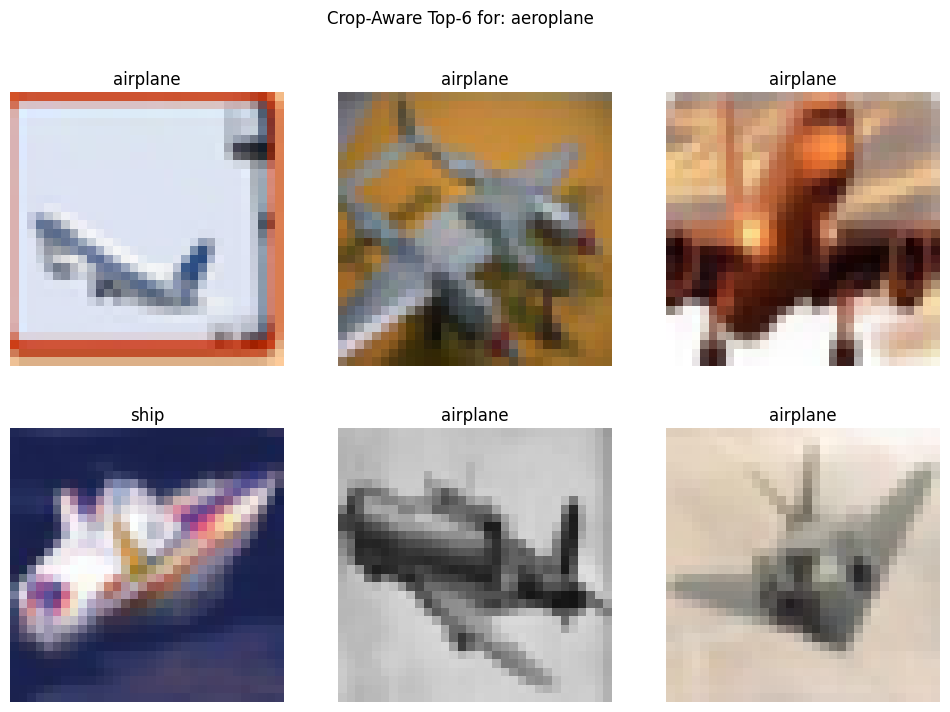

In [ ]:
def search_crop_aware(query_emb, topk=6):
    full_scores = img_emb @ query_emb

    if crop_emb.shape[0] == 0:
        idx = np.argsort(-full_scores)[:topk]
        return idx, full_scores[idx]

    crop_scores = crop_emb @ query_emb
    best_crop = np.full((len(images),), -1e9, dtype=np.float32)
    np.maximum.at(best_crop, crop_image_ids, crop_scores)
    alpha = 0.7  # trust full image more
    scores = alpha * full_scores + (1 - alpha) * best_crop
    idx = np.argsort(-scores)[:topk]
    return idx, scores[idx]

idx2, sc2 = search_crop_aware(q_emb, topk=6)
print("✅ Step 10: Crop-aware retrieval done")
print("   Top labels:", [class_names[labels[i]] for i in idx2])
show_results(idx2, title=f"Crop-Aware Top-6 for: {q}")


In [ ]:
def recall_mrr(search_fn, ks=(1,5,10)):
    recalls = {k: 0 for k in ks}
    mrr_sum = 0.0
    n = len(captions)

    # Pre-encode all query texts in one go for speed
    q_all = encode_text(captions)

    for i in tqdm(range(n), desc="Evaluating"):
        q = q_all[i]
        target_label = labels[i]

        # get ranking over all images
        if search_fn.__name__ == "baseline_rank":
            scores = img_emb @ q
        else:
            full_scores = img_emb @ q
            if crop_emb.shape[0] > 0:
                crop_scores = crop_emb @ q
                best_crop = np.full((n,), -1e9, dtype=np.float32)
                np.maximum.at(best_crop, crop_image_ids, crop_scores)
                scores = np.maximum(full_scores, best_crop)
            else:
                scores = full_scores

        ranked = np.argsort(-scores)

        # relevance: same label
        rel = np.array([labels[j] == target_label for j in ranked])

        # Recall@K
        for k in ks:
            if rel[:k].any():
                recalls[k] += 1

        # MRR
        first = np.argmax(rel)  # index of first True; returns 0 if first is True, but if none True => 0 (bad)
        if rel.any():
            mrr_sum += 1.0 / (first + 1)

    for k in recalls:
        recalls[k] /= n
    mrr = mrr_sum / n
    return recalls, mrr

# wrapper names for check
def baseline_rank(q): pass
def crop_rank(q): pass

rec_b, mrr_b = recall_mrr(baseline_rank, ks=(1,5,10))
rec_c, mrr_c = recall_mrr(crop_rank, ks=(1,5,10))

print("✅ Step 11: Evaluation complete")
print("Baseline  Recall@1/5/10:", rec_b, "MRR:", round(mrr_b, 4))
print("CropAware Recall@1/5/10:", rec_c, "MRR:", round(mrr_c, 4))


Evaluating: 100%|██████████| 200/200 [00:00<00:00, 8908.04it/s]

✅ Step 11: Evaluation complete
Baseline  Recall@1/5/10: {1: 0.91, 5: 1.0, 10: 1.0} MRR: 0.955
CropAware Recall@1/5/10: {1: 0.8, 5: 1.0, 10: 1.0} MRR: 0.9


In [ ]:
print("Baseline  Recall@1/5/10:", rec_b, "MRR:", round(mrr_b, 4))
print("CropAware Recall@1/5/10:", rec_c, "MRR:", round(mrr_c, 4))


Baseline  Recall@1/5/10: {1: 0.91, 5: 1.0, 10: 1.0} MRR: 0.955
CropAware Recall@1/5/10: {1: 0.8, 5: 1.0, 10: 1.0} MRR: 0.9


In [ ]:
print("crop_emb shape:", crop_emb.shape)
print("num crops:", len(crop_image_ids))
print("unique images with crops:", len(set(crop_image_ids.tolist())) if len(crop_image_ids)>0 else 0)


crop_emb shape: (213, 512)
num crops: 213
unique images with crops: 141


Image to Text

In [ ]:
!pip -q install torch torchvision pillow
!pip -q install transformers



In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
print("Device:", device)


Device: cuda


In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch.nn.functional as F

model_name = "openai/clip-vit-base-patch32"
clip = CLIPModel.from_pretrained(model_name).to(device).eval()
processor = CLIPProcessor.from_pretrained(model_name)

# Build text prompts for classes
text_prompts = [f"a photo of a {c}" for c in classes]

@torch.no_grad()
def classify_image_clip(pil_img):
    # Encode image
    inputs = processor(images=pil_img, return_tensors="pt").to(device)
    img_feat = clip.get_image_features(**inputs)
    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

    # Encode text classes
    t_in = processor(text=text_prompts, return_tensors="pt", padding=True).to(device)
    txt_feat = clip.get_text_features(**t_in)
    txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)

    # Cosine similarities
    sims = (img_feat @ txt_feat.T).squeeze(0)  # (10,)
    probs = F.softmax(sims, dim=0).detach().cpu().numpy()

    pred = int(np.argmax(probs))
    return classes[pred], float(probs[pred]), probs


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
from google.colab import files

def topk_predictions(probs, k=3):
    idx = np.argsort(-probs)[:k]
    return [(classes[i], float(probs[i])) for i in idx]


uploaded = files.upload()  # choose a file
img_path = next(iter(uploaded.keys()))
img = Image.open(img_path).convert("RGB")

label, conf, probs = classify_image_clip(img)
print("✅ Top-1:", label, round(conf, 3))
print("✅ Probability:", [(c, round(p,3)) for c,p in topk_predictions(probs, 3)])


Saving WhatsApp Image 2025-12-12 at 23.05.46_8ca244c1.jpg to WhatsApp Image 2025-12-12 at 23.05.46_8ca244c1.jpg
✅ Top-1: dog 0.106
✅ Probability: [('dog', 0.106), ('horse', 0.102), ('deer', 0.1)]


In [ ]:
def topk_predictions(probs, k=3):
    idx = np.argsort(-probs)[:k]
    return [(classes[i], float(probs[i])) for i in idx]

label, conf, probs = classify_image_clip(img)
print("✅ Top-1:", label, round(conf, 3))
print("✅ Top-3:", [(c, round(p,3)) for c,p in topk_predictions(probs, 3)])


✅ Top-1: dog 0.106
✅ Top-3: [('dog', 0.106), ('horse', 0.102), ('deer', 0.1)]
